In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import ndcg_score
from lightgbm import early_stopping, log_evaluation,LGBMRanker

In [2]:
def load_dataset(filename):
    return pd.read_csv(filename)

training_file_raw = 'training_set_VU_DM.csv'
test_file_raw = 'test_set_VU_DM.csv'
training_file_stats = 'training_set_stats_VU_DM.csv'
test_file_stats = 'test_set_stats_VU_DM.csv'

In [3]:
def dataset_stats(df):
    print(f'Number of features: {len(df.columns)}')
    total_observations = len(df)
    print(f'Number of observations: {len(df)}')
    print(f'Number of rows with missing values: {df.isnull().any(axis=1).sum()}')
    print(f'Number of columns with missing values: {df.isnull().any(axis=0).sum()}')
    print(f'Percentage not-missing data for features with missing values:')
    for feature in df.columns[df.isnull().any()]:
        print(f"{feature}: {100*(total_observations - df[feature].isnull().sum())/total_observations:.2f}% not missing")
dataset_stats(load_dataset(training_file_raw))

Number of features: 54
Number of observations: 4958347
Number of rows with missing values: 4958347
Number of columns with missing values: 31
Percentage not-missing data for features with missing values:
visitor_hist_starrating: 5.08% not missing
visitor_hist_adr_usd: 5.10% not missing
prop_review_score: 99.85% not missing
prop_location_score2: 78.01% not missing
srch_query_affinity_score: 6.40% not missing
orig_destination_distance: 67.57% not missing
comp1_rate: 2.42% not missing
comp1_inv: 2.61% not missing
comp1_rate_percent_diff: 1.90% not missing
comp2_rate: 40.83% not missing
comp2_inv: 42.96% not missing
comp2_rate_percent_diff: 11.22% not missing
comp3_rate: 30.94% not missing
comp3_inv: 33.30% not missing
comp3_rate_percent_diff: 9.54% not missing
comp4_rate: 6.20% not missing
comp4_inv: 6.93% not missing
comp4_rate_percent_diff: 2.64% not missing
comp5_rate: 44.82% not missing
comp5_inv: 47.60% not missing
comp5_rate_percent_diff: 16.96% not missing
comp6_rate: 4.84% not miss

In [4]:
df_train = load_dataset(training_file_raw)
df_test = load_dataset(test_file_raw)

In [5]:
print(min(df_train['prop_starrating']))

0


In [6]:
def add_engineered_columns(df_raw):
    df = df_raw.copy()

    df.loc[df['price_usd'] > 2060.0355, 'price_usd'] = np.nan # 0.999 percent of data maar kunnen dit nog aanpassen
    df['price_per_night'] = df['price_usd'] / df['srch_length_of_stay']
    df['month'] = pd.to_datetime(df['date_time']).dt.month

    df['review_score_relative'] = (df['prop_review_score'] - df.groupby('srch_id')['prop_review_score'].transform('median'))
    df['price_relative'] = (df['price_usd'] - df.groupby('srch_id')['price_usd'].transform('median'))

    df['log_price_usd'] = np.log1p(df['price_usd'])
    df['log_price_per_night'] = np.log1p(df['price_per_night'])

    df['orig_dest_missing'] = df['orig_destination_distance'].isna().astype(int)
    df['loc_score2_missing'] = df['prop_location_score2'].isna().astype(int)

    #for col in ['orig_destination_distance', 'prop_location_score2']:
    #    if col in df.columns:
    #        df[col] = df[col].fillna(df[col].median())
    return df

In [9]:
def compute_prop_stats(df):
    exclude = [
        'srch_id', 'prop_id', 'position', 'click_bool', 'booking_bool',
        'gross_bookings_usd', 'relevance', 'price_usd', 'visitor_location_country_id',
        'prop_country_id', 'site_id', 'srch_destination_id'
    ]
    numeric = df.select_dtypes('number').columns.drop(exclude)
    means = df.groupby('prop_id')[numeric].mean().add_suffix('_mean')
    meds  = df.groupby('prop_id')[numeric].median().add_suffix('_median')
    stats = means.join(meds)
    return stats

def prepare_final_features(df, prop_stats):
    df = df.merge(prop_stats, on='prop_id', how='left')
    return df.drop(['position', 'click_bool', 'booking_bool', 'gross_bookings_usd', 'price_usd', 'date_time'], axis=1, errors='ignore') #ignores de waardes als er geen column is om te droppen

In [10]:
train_raw = pd.read_csv("training_set_VU_DM.csv")
test_raw  = pd.read_csv("test_set_VU_DM.csv")

train_fe = add_engineered_columns(train_raw)
test_fe  = add_engineered_columns(test_raw)

train_fe['relevance'] = 0
train_fe.loc[train_fe['click_bool'] == 1, 'relevance'] = 1
train_fe.loc[train_fe['booking_bool'] == 1, 'relevance'] = 5

prop_stats = compute_prop_stats(train_fe)

train_final = prepare_final_features(train_fe, prop_stats)
test_final  = prepare_final_features(test_fe, prop_stats)

In [11]:
X = train_final.drop(['srch_id', 'relevance'], axis=1)
y = train_final['relevance']

groups = train_final.groupby('srch_id').size().to_numpy()
gss = GroupShuffleSplit(test_size=0.2, random_state=1)
train_idx, test_idx = next(gss.split(X, y, groups=train_final['srch_id']))

X_train_all = X.iloc[train_idx]
y_train_all = y.iloc[train_idx]
groups_train_all = train_final.iloc[train_idx]['srch_id']

gss_val = GroupShuffleSplit(test_size=0.2, random_state=2)
train_idx_final, val_idx = next(gss_val.split(X_train_all, y_train_all, groups=groups_train_all))

X_train, y_train = X_train_all.iloc[train_idx_final], y_train_all.iloc[train_idx_final]
X_val, y_val = X_train_all.iloc[val_idx], y_train_all.iloc[val_idx]

train_group = groups_train_all.iloc[train_idx_final].value_counts().sort_index().to_numpy()
val_group   = groups_train_all.iloc[val_idx].value_counts().sort_index().to_numpy()

model = LGBMRanker(
    objective='lambdarank',
    metric='ndcg',
    ndcg_eval_at=[5],
    learning_rate=0.1,
    num_leaves=64,
    min_data_in_leaf=30,
    feature_fraction=0.85,
    n_estimators=3000
)

model.fit(
    X_train, y_train,
    group=train_group,
    eval_set=[(X_val, y_val)],
    eval_group=[val_group],
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(period=50)]
)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21857
[LightGBM] [Info] Number of data points in the train set: 3172170, number of used features: 155
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] 

LGBMRanker(feature_fraction=0.85, metric='ndcg', min_data_in_leaf=30,
           n_estimators=3000, ndcg_eval_at=[5], num_leaves=64,
           objective='lambdarank')

In [12]:
test_df = test_final.copy()
X_submit = test_df[model.feature_name_]

lgb_pred = model.predict(X_submit)
test_df['pred'] = lgb_pred

test_df_filtered = test_df[['srch_id', 'prop_id', 'pred']]
test_df_sorted = test_df_filtered.sort_values(by=["srch_id", "pred"], ascending=[True, False])

df_submission = test_df_sorted.drop(columns=['pred'])
df_submission.to_csv('VU-DM-2025-Group-23.csv', index=False)
print('file done')

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/sklearn.py:861: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


### with season and df['review_score_relative'] and df['price_relative']:
[50]	valid_0's ndcg@5: 0.384948
[100]	valid_0's ndcg@5: 0.393628
[150]	valid_0's ndcg@5: 0.398359
[200]	valid_0's ndcg@5: 0.399565
[250]	valid_0's ndcg@5: 0.400185
Early stopping, best iteration is:
Mean NDCG@5 (LightGBM): 0.4034

### without season Training until validation scores don't improve for 30 rounds
[50]	valid_0's ndcg@5: 0.384623
[100]	valid_0's ndcg@5: 0.3935
[150]	valid_0's ndcg@5: 0.397363
[200]	valid_0's ndcg@5: 0.399755
[250]	valid_0's ndcg@5: 0.400439
Early stopping, best iteration is:
[230]	valid_0's ndcg@5: 0.400646

### with log prices 

[50]	valid_0's ndcg@5: 0.385696
[100]	valid_0's ndcg@5: 0.394602
[150]	valid_0's ndcg@5: 0.399661
[200]	valid_0's ndcg@5: 0.401758
[250]	valid_0's ndcg@5: 0.401512
Early stopping, best iteration is:
[222]	valid_0's ndcg@5: 0.401854

### median imputation for 'orig_destination_distance', 'prop_location_score2'
Training until validation scores don't improve for 30 rounds
[50]	valid_0's ndcg@5: 0.385749
[100]	valid_0's ndcg@5: 0.394676
[150]	valid_0's ndcg@5: 0.398052
[200]	valid_0's ndcg@5: 0.400436
Early stopping, best iteration is:
[212]	valid_0's ndcg@5: 0.400778

In [ ]:
importance = model.feature_importances_
print(importance)

In [13]:
importances = model.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df.head(20))
print('number of features',len(feature_importance_df))

                              feature  importance
51                      log_price_usd         835
50                     price_relative         763
10               prop_location_score2         635
9                prop_location_score1         331
112  prop_log_historical_price_median         320
47                    price_per_night         315
61          prop_location_score2_mean         305
20          srch_query_affinity_score         295
150             price_relative_median         272
72                   random_bool_mean         270
70     srch_query_affinity_score_mean         254
11          prop_log_historical_price         250
101                log_price_usd_mean         249
85                    comp5_rate_mean         244
100               price_relative_mean         238
151              log_price_usd_median         221
6                     prop_starrating         212
99         review_score_relative_mean         211
111       prop_location_score2_median         210


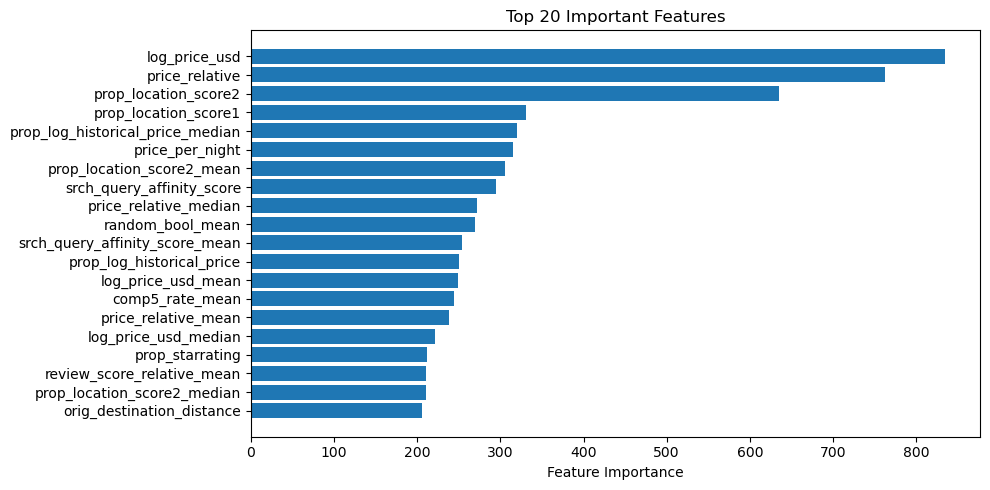

In [16]:

top_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Important Features")
plt.tight_layout()
plt.show()

In [ ]:
feature_importance_df.to_csv('features_importance.csv', index=False)